Автор: Лейман М.А.  
Дата создания: 14.06.2025 

# Итоговая аттестация 
### __проект 7:__   _Семантическая сегментация с помощью U-Net на уличных сценах_  



## DeepLab


## Импорты 

In [2]:

from data.dataset import CityscapesFlatDataset, CityscapesFlatDataset2, CityscapesFlatDataset3, prepare_cityscapes_loaders
from utils.utils import emty_cache, visualize_image_and_mask, visualize_segmentation
from model.train import train_model
from model.predict import prediction_mask

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' 
import warnings
import copy
import torch.optim as optim
import time
import numpy as np
import torch
from torch.utils.data import random_split, DataLoader
from torchsummary import summary
from tqdm import tqdm
from torch.optim import lr_scheduler
from matplotlib import rcParams
import shutil
from PIL import Image
from torch.utils.data import Dataset
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import gc

warnings.filterwarnings("ignore")
np.random.seed(42)
#set_global_seed(42)
rcParams['figure.figsize'] = (14,6)

## Параметры

In [3]:
# Классы
CITYSCAPES_PALETTE = np.array([
    [0, 0, 0],      # ФОН
    [128, 64,128],  # road
    [244, 35,232],  # sidewalk
    [70, 70, 70],   # building
    [102,102,156],  # wall
    [190,153,153],  # fence
    [153,153,153],  # pole
    [250,170, 30],  # traffic light
    [220,220,  0],  # traffic sign
    [107,142, 35],  # vegetation
    [152,251,152],  # terrain
    [70,130,180],   # sky
    [220, 20, 60],  # person
    [255,  0,  0],  # rider
    [0,  0,142],    # car
    [0,  0, 70],    # truck
    [0, 60,100],    # bus
    [0, 80,100],    # train
    [0,  0,230],    # motorcycle
    [119, 11, 32],  # bicycle
])


In [4]:
# устанавливаем device если gpu или cpu


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("работаем на устройстве: ", device)
print('Версия torch:           ', torch.__version__)
print("версия  cuDNN:          ", torch.backends.cudnn.version())

# ПРОВЕРКА GPU
!nvidia-smi

работаем на устройстве:  cuda
Версия torch:            2.7.1+cu126
версия  cuDNN:           90501
Mon Jun 30 12:24:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:01:00.0  On |                  N/A |
| 45%   66C    P2            121W /  170W |   11293MiB /  12288MiB |     98%      Default |
|                                         

## Загрузка данных 

### Датасет

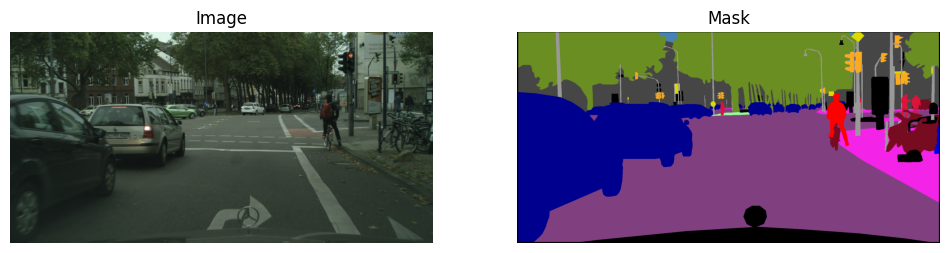

In [5]:
# Загрузка с PIL
root_dir = './dataset/dataset'
dataset = CityscapesFlatDataset(root_dir)
image, mask = dataset[10]
visualize_image_and_mask(image, mask, class_palette=CITYSCAPES_PALETTE)

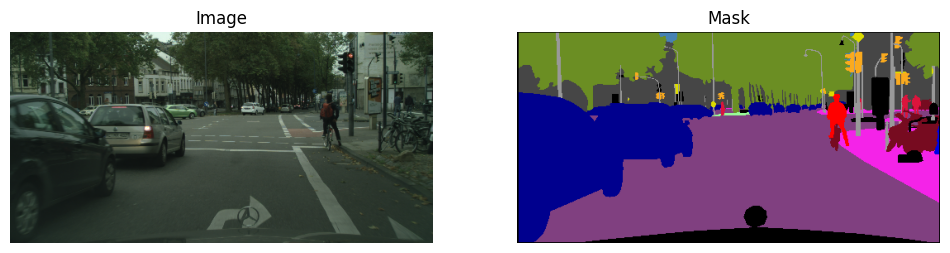

In [6]:
# Загрузка с OpenCV
root_dir = './dataset/dataset'
dataset = CityscapesFlatDataset2(root_dir)
image, mask = dataset[10]

visualize_image_and_mask(image, mask, class_palette=CITYSCAPES_PALETTE)

In [7]:
print(np.unique(mask))


[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 18 19]


### Разделение датасета

In [ ]:
batch_size = 16
size = 256, 512


train_loader, val_loader, train_dataset, val_dataset = prepare_cityscapes_loaders(CityscapesFlatDataset3, './dataset/dataset_split',
                            size,
                            batch_size=batch_size,
                            num_workers=0,
                            p_hflip=0.3,
                            p_brightness=0.1,
                            p_noise=0.1,
                            p_swap_channels=0.01, 
                            p_contrast=0.1,
                            p_saturation=0.1)

Train size: 9383, Validation size: 1042


## Модели

### 2) __DeepLabV3Plus__  

In [ ]:
import segmentation_models_pytorch as smp
import torch

# Параметры модели
ENCODER = "resnet34"           
ENCODER_WEIGHTS = "imagenet"   
CLASSES = 20                   
ACTIVATION = None             

# Создаем модель DeepLabV3+
model_deeplab = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=CLASSES,
    activation=ACTIVATION,
)


## Обучение

### 2) DeepLabV3Plus

Epoch 1 Val: 100%|██████████| 65/65 [00:25<00:00,  2.59it/s, acc=0.906, iou=0.546, loss=0.275]


Epoch 1 summary: Train Loss: 0.2567, Acc: 0.9138, IoU: 0.5526 | Val Loss: 0.2912, Acc: 0.9147, IoU: 0.5009
Сохранена лучшая модель 1 с val IoU: 0.5009


Epoch 2 Val: 100%|██████████| 65/65 [00:24<00:00,  2.64it/s, acc=0.906, iou=0.542, loss=0.282]


Epoch 2 summary: Train Loss: 0.2405, Acc: 0.9190, IoU: 0.5727 | Val Loss: 0.2923, Acc: 0.9157, IoU: 0.5041
Сохранена лучшая модель 2 с val IoU: 0.5041


Epoch 3 Val: 100%|██████████| 65/65 [00:24<00:00,  2.63it/s, acc=0.908, iou=0.531, loss=0.275]


Epoch 3 summary: Train Loss: 0.2271, Acc: 0.9227, IoU: 0.5915 | Val Loss: 0.2882, Acc: 0.9176, IoU: 0.5072
Сохранена лучшая модель 3 с val IoU: 0.5072


Epoch 4 Val: 100%|██████████| 65/65 [00:24<00:00,  2.63it/s, acc=0.908, iou=0.527, loss=0.287]


Epoch 4 summary: Train Loss: 0.2170, Acc: 0.9270, IoU: 0.6024 | Val Loss: 0.2921, Acc: 0.9181, IoU: 0.5091
Сохранена лучшая модель 4 с val IoU: 0.5091


Epoch 5 Val: 100%|██████████| 65/65 [00:24<00:00,  2.63it/s, acc=0.91, iou=0.534, loss=0.274] 


Epoch 5 summary: Train Loss: 0.2111, Acc: 0.9283, IoU: 0.6121 | Val Loss: 0.2906, Acc: 0.9199, IoU: 0.5120
Сохранена лучшая модель 5 с val IoU: 0.5120


Epoch 6 Val: 100%|██████████| 65/65 [00:25<00:00,  2.57it/s, acc=0.912, iou=0.544, loss=0.262]


Epoch 6 summary: Train Loss: 0.1929, Acc: 0.9333, IoU: 0.6326 | Val Loss: 0.2817, Acc: 0.9221, IoU: 0.5225
Сохранена лучшая модель 6 с val IoU: 0.5225


Epoch 7 Val: 100%|██████████| 65/65 [00:25<00:00,  2.57it/s, acc=0.913, iou=0.559, loss=0.257]


Epoch 7 summary: Train Loss: 0.1869, Acc: 0.9353, IoU: 0.6425 | Val Loss: 0.2811, Acc: 0.9227, IoU: 0.5250
Сохранена лучшая модель 7 с val IoU: 0.5250


Epoch 8 Val: 100%|██████████| 65/65 [00:24<00:00,  2.63it/s, acc=0.913, iou=0.558, loss=0.261]


Epoch 8 summary: Train Loss: 0.1828, Acc: 0.9369, IoU: 0.6468 | Val Loss: 0.2823, Acc: 0.9224, IoU: 0.5250
Сохранена лучшая модель 8 с val IoU: 0.5250


Epoch 9 Val: 100%|██████████| 65/65 [00:25<00:00,  2.58it/s, acc=0.912, iou=0.553, loss=0.256]


Epoch 9 summary: Train Loss: 0.1795, Acc: 0.9378, IoU: 0.6506 | Val Loss: 0.2858, Acc: 0.9224, IoU: 0.5218


Epoch 10 Val: 100%|██████████| 65/65 [00:24<00:00,  2.64it/s, acc=0.913, iou=0.562, loss=0.251]


Epoch 10 summary: Train Loss: 0.1760, Acc: 0.9390, IoU: 0.6562 | Val Loss: 0.2848, Acc: 0.9230, IoU: 0.5218


Epoch 11 Val: 100%|██████████| 65/65 [00:24<00:00,  2.64it/s, acc=0.913, iou=0.563, loss=0.254]


Epoch 11 summary: Train Loss: 0.1718, Acc: 0.9399, IoU: 0.6620 | Val Loss: 0.2866, Acc: 0.9230, IoU: 0.5260
Сохранена лучшая модель 11 с val IoU: 0.5260


Epoch 12 Val: 100%|██████████| 65/65 [00:24<00:00,  2.64it/s, acc=0.913, iou=0.57, loss=0.253] 


Epoch 12 summary: Train Loss: 0.1696, Acc: 0.9413, IoU: 0.6640 | Val Loss: 0.2893, Acc: 0.9230, IoU: 0.5253


Epoch 13 Val: 100%|██████████| 65/65 [00:24<00:00,  2.63it/s, acc=0.913, iou=0.563, loss=0.25] 


Epoch 13 summary: Train Loss: 0.1685, Acc: 0.9412, IoU: 0.6702 | Val Loss: 0.2878, Acc: 0.9229, IoU: 0.5236


Epoch 14 Val: 100%|██████████| 65/65 [00:24<00:00,  2.62it/s, acc=0.913, iou=0.565, loss=0.253]


Epoch 14 summary: Train Loss: 0.1678, Acc: 0.9413, IoU: 0.6681 | Val Loss: 0.2901, Acc: 0.9229, IoU: 0.5248


Epoch 15 Val: 100%|██████████| 65/65 [00:24<00:00,  2.63it/s, acc=0.913, iou=0.571, loss=0.251]


Epoch 15 summary: Train Loss: 0.1667, Acc: 0.9412, IoU: 0.6695 | Val Loss: 0.2919, Acc: 0.9230, IoU: 0.5234


Epoch 16 Val: 100%|██████████| 65/65 [00:24<00:00,  2.64it/s, acc=0.913, iou=0.573, loss=0.25] 


Epoch 16 summary: Train Loss: 0.1651, Acc: 0.9420, IoU: 0.6718 | Val Loss: 0.2907, Acc: 0.9229, IoU: 0.5248


Epoch 17 Val: 100%|██████████| 65/65 [00:24<00:00,  2.64it/s, acc=0.913, iou=0.564, loss=0.252]


Epoch 17 summary: Train Loss: 0.1647, Acc: 0.9420, IoU: 0.6720 | Val Loss: 0.2916, Acc: 0.9229, IoU: 0.5240


Epoch 18 Val: 100%|██████████| 65/65 [00:24<00:00,  2.63it/s, acc=0.913, iou=0.567, loss=0.252]


Epoch 18 summary: Train Loss: 0.1645, Acc: 0.9422, IoU: 0.6724 | Val Loss: 0.2915, Acc: 0.9232, IoU: 0.5246


Epoch 19 Val: 100%|██████████| 65/65 [00:25<00:00,  2.57it/s, acc=0.913, iou=0.566, loss=0.253]


Epoch 19 summary: Train Loss: 0.1644, Acc: 0.9424, IoU: 0.6767 | Val Loss: 0.2922, Acc: 0.9229, IoU: 0.5235


Epoch 20 Val: 100%|██████████| 65/65 [00:24<00:00,  2.65it/s, acc=0.913, iou=0.567, loss=0.254]


Epoch 20 summary: Train Loss: 0.1637, Acc: 0.9425, IoU: 0.6739 | Val Loss: 0.2915, Acc: 0.9230, IoU: 0.5254


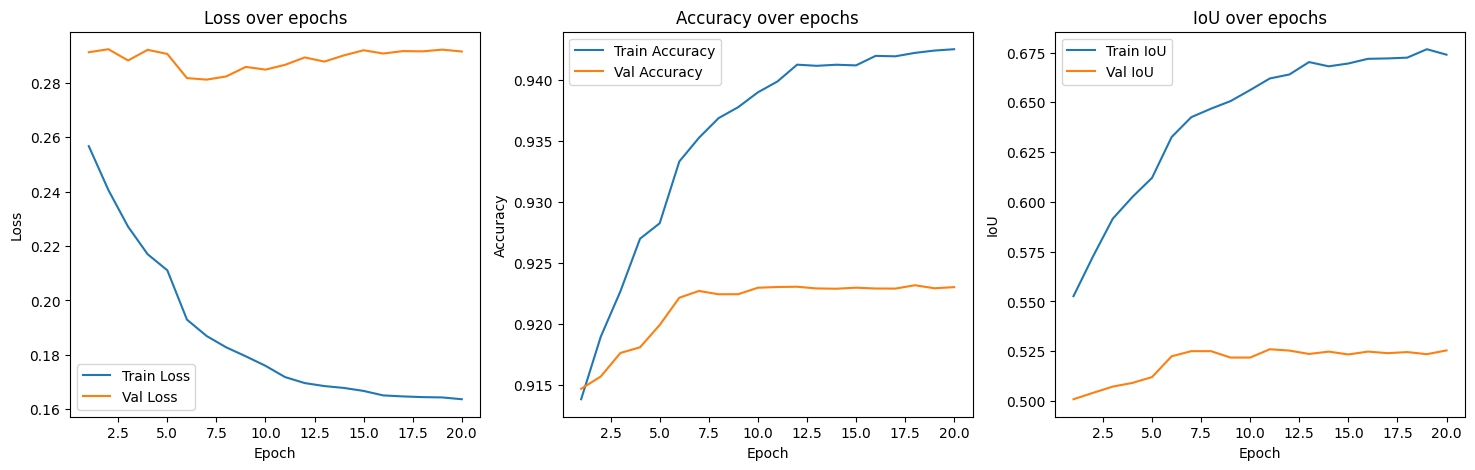

In [11]:
model_deeplab.load_state_dict(torch.load('models/deeplab_model2.pth', map_location=torch.device('cpu'))) 
emty_cache()
optimizer = torch.optim.Adam(model_deeplab.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)




train_model(model_deeplab, train_loader, val_loader, optimizer, device, num_epochs=20, scheduler=scheduler, save_path='models/deeplab_model2.pth')

## Использование модели

In [12]:
model_deeplab.load_state_dict(torch.load('models/deeplab_model2.pth', map_location=torch.device(device))) 
model_deeplab.eval();
model_deeplab = model_deeplab.to(device)




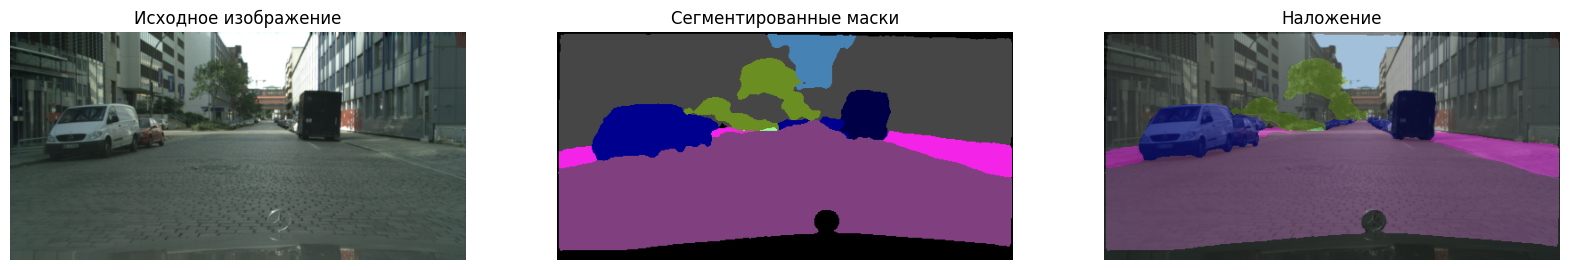

In [15]:
path_img = './dataset/dataset/images2/train/hamburg/hamburg_000000_008494_leftImg8bit.png'


img, prediction = prediction_mask(path_img, model_deeplab)
visualize_segmentation(img, prediction, CITYSCAPES_PALETTE)

# Работа модели на  изображении не с датасета

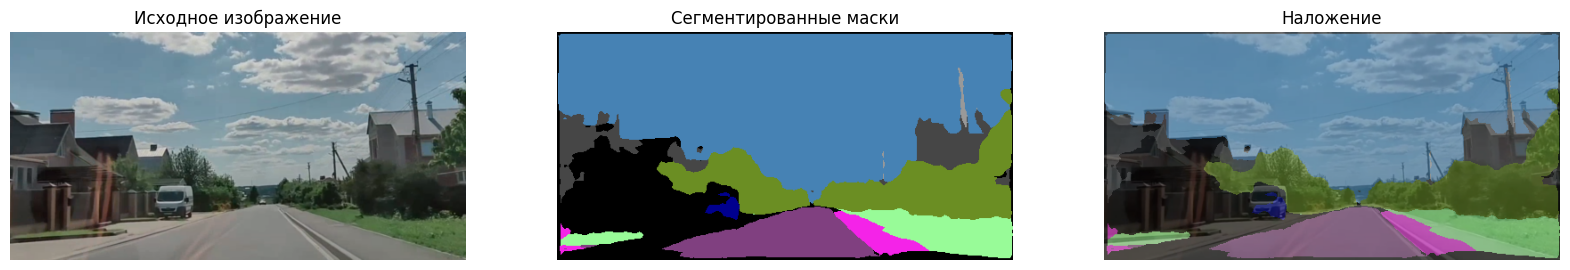

In [12]:
model_deeplab.load_state_dict(torch.load('models/deeplab_model.pth', map_location=torch.device(device))) 
model_deeplab.eval();
model_deeplab = model_deeplab.to(device)
path_img = '/home/maksim/develops/python/MAKSIM/Attestation/videos/1.png'


img, prediction = prediction_mask(path_img, model_deeplab)
visualize_segmentation(img, prediction, CITYSCAPES_PALETTE)

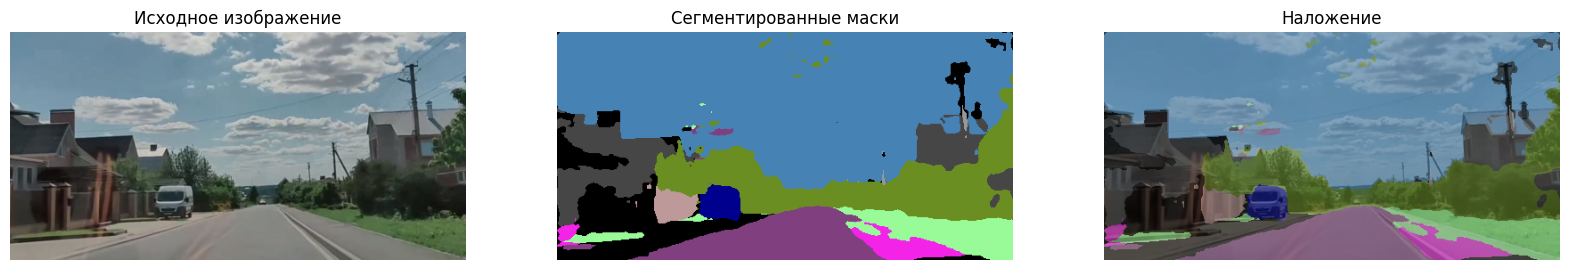

In [13]:
model_deeplab.load_state_dict(torch.load('models/deeplab_model2.pth', map_location=torch.device(device))) 
model_deeplab.eval();
model_deeplab = model_deeplab.to(device)
path_img = '/home/maksim/develops/python/MAKSIM/Attestation/videos/1.png'


img, prediction = prediction_mask(path_img, model_deeplab)
visualize_segmentation(img, prediction, CITYSCAPES_PALETTE)